In [33]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# grhpviz
from sklearn.tree import export_graphviz
import graphviz

# 기계 학습 모델 필요 모듈
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler


# 모델 성능 평가
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.metrics import recall_score, precision_score

# 주피터 노트북 사용시 그래프 자동 출력 옵션
matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 데이터 구성

In [11]:
df_raw = pd.read_csv("Data/HMEQ.csv")
df_raw.info()

# 결측치
## 범주형 변수
df_raw["JOB"].fillna("Other", inplace=True)

## 연속형 변수: 결측치 있는 모든 열을 평균으로 대체
df_raw.fillna(df_raw.mean(), inplace =True)
df_raw.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3748 non-null   int64  
 1   LOAN     3748 non-null   int64  
 2   MORTDUE  3748 non-null   int64  
 3   VALUE    3734 non-null   float64
 4   REASON   3748 non-null   object 
 5   JOB      3667 non-null   object 
 6   YOJ      3543 non-null   float64
 7   DEROG    3748 non-null   int64  
 8   DELINQ   3718 non-null   float64
 9   CLAGE    3711 non-null   float64
 10  NINQ     3692 non-null   float64
 11  CLNO     3748 non-null   int64  
 12  DEBTINC  3748 non-null   float64
dtypes: float64(6), int64(5), object(2)
memory usage: 380.8+ KB


BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [12]:
# 더미변수 생성 (목표변수가 0과 1이라서 더미변수 바로 돌릴 수 있었다.)
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

## 데이터 분리
df_raw_y = df_raw_dummy["BAD"]
df_raw_x = df_raw_dummy.drop("BAD", axis=1, inplace = False)

In [24]:
## 데이터 스플릿 (7:3으로 train/test데이터를 나눈다.)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (2623, 18)
train data Y size: (2623,)
test data X size: (1125, 18)
test data Y size: (1125,)


## 데이터 전처리
※ 더미변수는 범주형 설명변수를 0과 1로 변경해서 모델을 돌릴 수 있게 해준다.   
※ 목표변수는 스케일링하지 않는다.

In [25]:
model = ["DecisionTree", "RandomForest", "GradientBoosting", "NeuralNet"]

train_accuracy=[]; test_accuracy=[]
model_auc=[]
model_f1_score = []
model_recall=[]
model_precision=[]

### 의사결정나무

In [26]:
dt_model = DecisionTreeClassifier(max_depth = 4, min_samples_leaf=30)
dt_model.fit(df_train_x, df_train_y)

# train/test 정확도
train_accuracy.append(dt_model.score(df_train_x, df_train_y))
test_accuracy.append(dt_model.score(df_test_x, df_test_y))

# 예측값
y_pred = dt_model.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr = FP / (FP+TN): 거짓 양성 비율, tpr = TP/(TP+FN): 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)

# auc저장
model_auc.append(roc_auc)

# f1스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

# 재현율과 정밀도
model_recall.append(recall_score(df_test_y, y_pred))
model_precision.append(precision_score(df_test_y, y_pred))

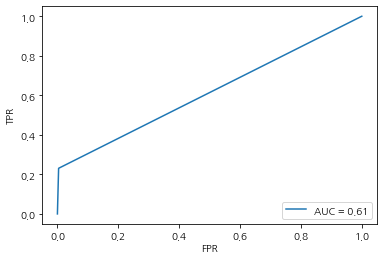

In [27]:
## roc curve 그리기, label에 auc 표시
plt.plot(fpr, tpr, label="AUC = %0.2f"%roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.show()


### 랜덤포레스트

In [28]:
rf_model = RandomForestClassifier(max_depth = 4, min_samples_leaf=20, n_estimators=100, random_state=1234)
rf_model.fit(df_train_x, df_train_y)

# train/test 정확도
train_accuracy.append(rf_model.score(df_train_x, df_train_y))
test_accuracy.append(rf_model.score(df_test_x, df_test_y))

# 예측값
y_pred = rf_model.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr = FP / (FP+TN): 거짓 양성 비율, tpr = TP/(TP+FN): 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)

# auc저장
model_auc.append(roc_auc)

# f1스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

# 재현율과 정밀도
model_recall.append(recall_score(df_test_y, y_pred))
model_precision.append(precision_score(df_test_y, y_pred))

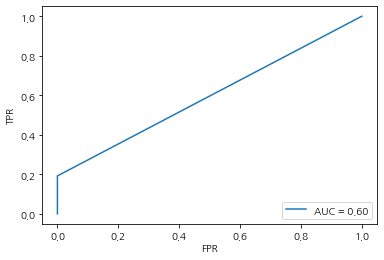

In [29]:
## roc curve 그리기, label에 auc 표시
plt.plot(fpr, tpr, label="AUC = %0.2f"%roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.show()


### 그레디언트 부스팅

In [30]:
gb_final = GradientBoostingClassifier(max_depth = 4, min_samples_leaf=10, n_estimators=100, learning_rate=0.1, random_state=1234)
gb_final.fit(df_train_x, df_train_y)

# train/test 정확도
train_accuracy.append(gb_final.score(df_train_x, df_train_y))
test_accuracy.append(gb_final.score(df_test_x, df_test_y))

# 예측값
y_pred = gb_final.predict(df_test_x)

# roc_curve(실제값, 예측값), fpr = FP / (FP+TN): 거짓 양성 비율, tpr = TP/(TP+FN): 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)

# auc저장
model_auc.append(roc_auc)

# f1스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

# 재현율과 정밀도
model_recall.append(recall_score(df_test_y, y_pred))
model_precision.append(precision_score(df_test_y, y_pred))

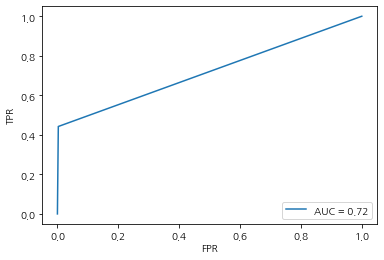

In [31]:
## roc curve 그리기, label에 auc 표시
plt.plot(fpr, tpr, label="AUC = %0.2f"%roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.show()


### 인공신경망

### 데이터 스케일링

In [34]:
v_feature_name = df_train_x.columns

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns=v_feature_name)

### 스케일링 데이터 분할
df_scaled_train_x, df_scaled_test_x= train_test_split(df_scaled, test_size=0.3, random_state=1234)

print("train data X size: {}".format(df_scaled_train_x.shape))
print("test data X size: {}".format(df_scaled_test_x.shape))


train data X size: (2623, 18)
test data X size: (1125, 18)


In [37]:
nn_model = MLPClassifier(hidden_layer_sizes=(80, 80), activation="relu", solver="adam", random_state=1234)
nn_model.fit(df_scaled_train_x, df_train_y)

# train/test 정확도
train_accuracy.append(nn_model.score(df_scaled_train_x, df_train_y))
test_accuracy.append(nn_model.score(df_scaled_test_x, df_test_y))

# 예측값
y_pred = nn_model.predict(df_scaled_test_x)

# roc_curve(실제값, 예측값), fpr = FP / (FP+TN): 거짓 양성 비율, tpr = TP/(TP+FN): 진짜 양성 비율(재현율)
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)

# auc저장
model_auc.append(roc_auc)

# f1스코어
model_f1_score.append(f1_score(df_test_y, y_pred))

# 재현율과 정밀도
model_recall.append(recall_score(df_test_y, y_pred))
model_precision.append(precision_score(df_test_y, y_pred))

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


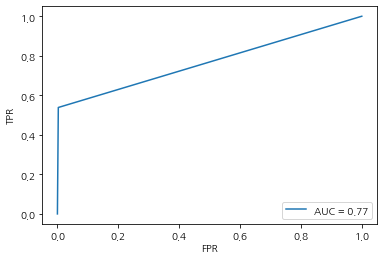

In [38]:
## roc curve 그리기, label에 auc 표시
plt.plot(fpr, tpr, label="AUC = %0.2f"%roc_auc)
plt.legend(loc="lower right")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.show()


## 모델별 정확도 산출

In [44]:
df_eval=pd.DataFrame(index=model)
df_eval["TrainAccuracy"]=train_accuracy
df_eval["TestAccuracy"]=test_accuracy
df_eval["F1Score"]=model_f1_score
df_eval["AUC"]=model_auc
df_eval["Predcision"] = model_precision
df_eval["Recall"] = model_recall
df_eval.round(3)

,TrainAccuracy,TestAccuracy,F1Score,AUC,Predcision,Recall
DecisionTree,0.930,0.925,0.364,0.613,0.857,0.231
RandomForest,0.927,0.925,0.323,0.596,1.000,0.192
GradientBoosting,0.977,0.946,0.601,0.720,0.939,0.442
NeuralNet,1.000,0.955,0.687,0.768,0.949,0.538


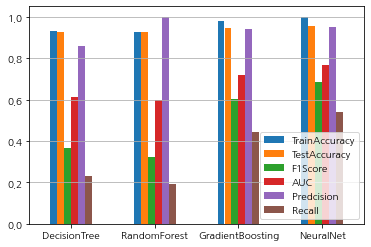

In [45]:
df_eval.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.grid(axis='y')

- 해당 지표를 보면 인공신경망 모델이 가장 높은 정확ㄷ와 F1 score, AUC를 보였다.
- 하지만 모델을 선정하기 전에 분석의 목표를 명확히 하는 것이 우선이다. 
    - 모델을 통한 개선안 도출이 필요하다면, 무엇을 분석할 지 명확히 선정하는 것이 중요하다.